# Bike Rental Ridership - in JULIA

This project takes and adapts the bike rental ridership machine learning exercise and adapts it to the GenML library
provided by [Interplanetary Robot](http://robots.earth).  Shortcut to the GenML github library:  https://github.com/interplanetary-robot/GenML

NB: Syntatic bindings to the GenML library are very likely to change.  This notebook may or may not be updated to reflect the changes.

In [1]:
#first, import the GenML library.
using GenML
using Gadfly  #for beautiful plots
using DataFrames

In [16]:
#next, load up the data.
data_path = "Bike-Sharing-Dataset/hour.csv"
rides = readtable(data_path);
head(rides)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.8,0.0,8,32,40
3,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.8,0.0,5,27,32
4,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1
6,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1


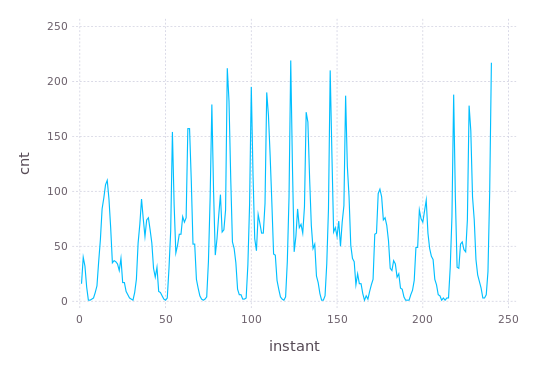

In [17]:
plot(rides[1:240,:], x=:instant, y=:cnt, Geom.line)

# Dummies and pruning

Unfortunately, Julia's DataFrame package doesn't come with a default dummy-izing procedure (yet!) but luckily it's really easy to implement!

Also a "drop" procedure is nice.

In [4]:
#adapted from https://groups.google.com/forum/#!topic/julia-users/7-Vtpi8w4YI

function getdummy(df::DataFrame, cname::Symbol)
  #strategy:  parse the entire dataframe column and then populate a hash of these things.
  
  #first pull the entire column as an array.
  data = df[cname]
  #calculate the levels coming off of this.
  new_df = DataFrame(Int.([(data[idx] == level) for idx = 1:length(data), level in levels(data)]))
  names!(new_df, [Symbol("$cname", "_", level) for level in levels(data)])
  new_df
end

function convertdummy(df::DataFrame, cnames::Vector{Symbol})
    #strategy:  convert to dummy categories by construction from empty.
    #create an empty dataframe.
    newdf = DataFrame()
    #go over the list of category names.
    for cname in names(df)
        #if it's not in the category we care about, transfer it over directly.
        if !in(cname, cnames)
            newdf[cname] = df[cname]
        else
            #call the getdummy function which produces a dataframe that has been dummy-ized.
            dummydf = getdummy(df, cname)
            
            #transfer those columns directly.
            for dummyname in names(dummydf)
                newdf[dummyname] = dummydf[dummyname]
            end
        end
    end
    return newdf
end

#another utility function we'll use.

function drop(df::DataFrame, cnames::Vector{Symbol})
  #strategy:  drop unwanted categories by construction from empty.
  #create an empty dataframe.
  newdf = DataFrame()
  #go over the list of category names.
  for cname in names(df)
    #if it's not in the category we care about, transfer it over directly.
    in(cname, cnames) || (newdf[cname] = df[cname])
  end           
  return newdf
end

drop (generic function with 1 method)

In [5]:
rides = convertdummy(rides, [:season, :weathersit, :mnth, :hr, :weekday])
rides = drop(rides, [:instant, :dteday])
head(rides)

,season_1,season_2,season_3,season_4,yr,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,holiday,weekday_6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,workingday,weathersit_1,weathersit_2,weathersit_3,weathersit_4,temp,atemp,hum,windspeed,casual,registered,cnt
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.24,0.2879,0.81,0.0,3,13,16
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.22,0.2727,0.8,0.0,8,32,40
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.22,0.2727,0.8,0.0,5,27,32
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.24,0.2879,0.75,0.0,3,10,13
5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.24,0.2879,0.75,0.0,0,1,1
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.24,0.2576,0.75,0.0896,0,1,1


# Scaling target variables

In [6]:
quantitative_features = [:casual, :registered, :cnt, :temp, :hum, :windspeed]
# Store scalings in a dictionary so we can convert back later
scaled_features = Dict{Symbol,Tuple{Float64, Float64}}()
for feature in quantitative_features
    f_mean = mean(rides[feature])
    f_std = std(rides[feature])
    
    scaled_features[feature] = (f_mean, f_std)
    rides[feature] = ((rides[feature] .- f_mean) ./ f_std)
end

head(rides)

,season_1,season_2,season_3,season_4,yr,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,holiday,weekday_6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,workingday,weathersit_1,weathersit_2,weathersit_3,weathersit_4,temp,atemp,hum,windspeed,casual,registered,cnt
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,-1.3346091869412826,0.2879,0.9473452433308971,-1.5538438052971006,-0.6627359960641203,-0.9301624851497269,-0.9563117241915204
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,-1.4384750099034225,0.2727,0.8955129279786795,-1.5538438052971006,-0.5613264652160683,-0.804631692988367,-0.8239983790667246
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,-1.4384750099034225,0.2727,0.8955129279786795,-1.5538438052971006,-0.6221721837248995,-0.8376661119781985,-0.8681028274416566
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,-1.3346091869412826,0.2879,0.636351351217592,-1.5538438052971006,-0.6627359960641203,-0.9499831365436259,-0.9728508923321199
5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,-1.3346091869412826,0.2879,0.636351351217592,-1.5538438052971006,-0.7235817145729514,-1.0094450907253227,-1.0390075648945178
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,-1.3346091869412826,0.2576,0.636351351217592,-0.8214600175171929,-0.7235817145729514,-1.0094450907253227,-1.0390075648945178


# data curation

In [7]:
test_data = rides[end - 21 * 24:end, :];
data = rides[1: end - 21 * 24, :];

# Separate the data into features and targets
target_fields = [:cnt, :casual, :registered]

#for both the main training data
targets = data[target_fields]
features = drop(data, target_fields)

#and the final test data.
test_targets = test_data[target_fields]
test_features = drop(test_data, target_fields);

test_features_raw = Matrix{Float32}(test_features)'
test_targets_raw = Vector{Float32}(test_targets[:,:cnt])

# repeat this for training/validation set.
train_features = features[1:end - 60 * 24, :]
train_targets  = targets[1:end - 60 * 24, :]

train_features_raw = Matrix{Float32}(train_features)'
train_targets_raw  = Matrix{Float32}(train_targets[:, [:cnt]])'

valid_features = features[end - 60 * 24:end, :]
valid_targets  = targets[end - 60 * 24:end, :];

valid_features_raw = Matrix{Float32}(valid_features)'
valid_targets_raw  = Matrix{Float32}(valid_targets[:, [:cnt]])'


1×1441 Array{Float32,2}:
 1.7506  3.58093  0.973258  0.151813  …  1.30955  0.609396  0.306178

In [26]:
#hyperparameters
#use 600 epochs for unbatched 
epochs = 600   
learning_rate = Float32(0.01)
structure = (58, 40, 1)

(58,40,1)

In [21]:
#instantiate the multilayer perceptron.
bike_model = GenML.MLP.MultilayerPerceptron{Float32, structure}(GenML.FCT.noderandomizer, [GenML.TF.sigmoid, GenML.TF.id])

GenML.MLP.MultilayerPerceptron{Float32,(58,40,1)}(GenML.FCT.FullyConnectedTransition{Float32,inputlength,outputlength,transferfunction}[GenML.FCT.FullyConnectedTransition{Float32,58,40,GenML.TF.sigmoid}(Float32[0.0658975,0.165777,-0.0424699,0.111728,0.221771,0.00238324,-0.224096,0.183935,0.142766,-0.0186784  …  0.255805,0.0474379,-0.0722959,-0.0119302,0.0292451,-0.184014,-0.222248,0.102695,-0.131984,0.119644],Float32[-0.142906 0.18071 … -0.3502 0.156614; 0.26386 0.063779 … 0.147023 -0.0855941; … ; -0.0142488 -0.0381831 … 0.0700063 -0.103627; 0.0225983 -0.0198952 … -0.0841262 -0.0927901]),GenML.FCT.FullyConnectedTransition{Float32,40,1,GenML.TF.id}(Float32[-0.804118],Float32[-0.117865 -0.0953314 … -0.188347 -0.0601264])])

In [22]:
datasize = size(train_features,1)

#the "evaluator" factory generates a closure function that makes it
#unnecessary to keep reallocating memory to for evaluation on training and valid sets.
train_loss_fn = GenML.evaluator(bike_model, train_features_raw)
valid_loss_fn = GenML.evaluator(bike_model, valid_features_raw)

#the "backpropagator" factory generates a closure function that facilitates backpropagation.

#arrays to log progress.
train_losses = Vector{Float32}(epochs)
valid_losses = Vector{Float32}(epochs)

@time for epoch = 1:epochs
  #generate a random permutation.
  randompermutation = randcycle(datasize)[1:128]
  #grab a random set of data for the batch.
  inputs_batch = train_features_raw[:, randompermutation]
  answer_batch = train_targets_raw[:, randompermutation]

  #doing batch backpropagation has slightly poorer results!
  GenML.Optimizers.backpropagationoptimize!(bike_model, input, answers, GenML.CF.meansquare,
     settings = GenML.BackpropSettings(learningrate = learning_rate))
    
  #for idx = 1:128
  #  GenML.Optimizers.backpropagationoptimize!(bike_model, inputs_batch[:,idx], answer_batch[:,idx], GenML.CF.meansquare, 
  #     settings = GenML.BackpropSettings(learningrate = learning_rate))
  #end
    
  #output the result of the backprop optimization.  This is lazy and memory intensive.  May want to address this.
    
  train_loss = GenML.CF.meansquare(train_loss_fn(), train_targets_raw)
  valid_loss = GenML.CF.meansquare(valid_loss_fn(), valid_targets_raw)

  train_losses[epoch] = train_loss
  valid_losses[epoch] = valid_loss
    
  print("\u1b[1A\rProgress: $(100 * epoch / epochs)% ... Training loss: $train_loss ... Validation loss: $valid_loss\r")
    
end

 80.626534 seconds (2.18 M allocations: 328.710 MB, 0.06% gc time): 0.08621034s: 0.089526915


NB: @time profiling really indicates that the calculation bottleneck is the "training loss" calculation.  It may be a good idea to roll that into a "superbatch" so that we aren't doing this as often as the validation loss calculation.

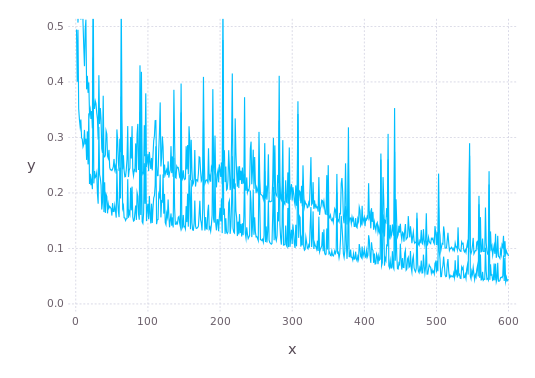

In [23]:
layer1 = layer(x=collect(1:epochs),y=train_losses, Geom.line)
layer2 = layer(x=collect(1:epochs),y=valid_losses, Geom.line)
plot(layer1, layer2, Coord.cartesian(ymin=0.0,ymax=0.5))

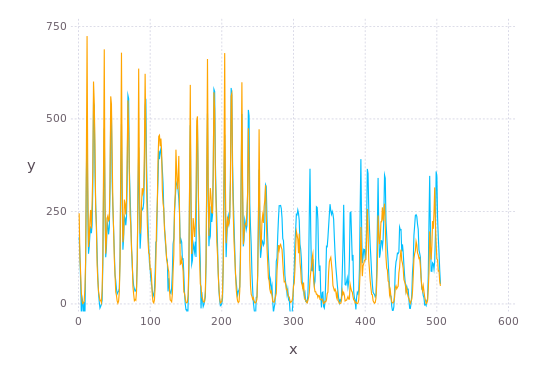

In [24]:
r_mean, r_std = scaled_features[:cnt]

adjust(x) = x * r_std + r_mean

actualdata = layer(x=collect(1:length(test_targets_raw)), y=adjust.(test_targets_raw), Geom.line, Theme(default_color=colorant"orange"))
predictions = layer(x=collect(1:length(test_targets_raw)), y=adjust.(bike_model(test_features_raw)), Geom.line)
plot(actualdata,predictions, Coord.cartesian(ymin=0.0,ymax=750))